In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import sklearn
import pandas as pd
import pandas as pd

import pandas as pd

import typing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import pandas as pd
import country_converter as coco
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

random_state = 123

##  Preprocessing:


In [2]:
import pandas as pd
import country_converter as coco


df = pd.read_csv("df_extended.csv", index_col=0)
df.shape

df['International Students'] = (
    df['International Students']
    .str.rstrip('%')
    .replace('', '0')
    .replace('N/A', 'N/A')
)

def convert_ratio(value):
    try:
        if ':' in value:
            parts = value.split(':')
            num1, num2 = float(parts[0]), float(parts[1])
            return num1 / num2
        else:
            return float(value)
    except:
        return None

df['Female to Male Ratio'] = df['Female to Male Ratio'].apply(convert_ratio)

country_to_continent = {}
def get_continent(country):
    if country not in country_to_continent:
        country_to_continent[country] = coco.CountryConverter().convert(names=country, to='continent')
    return country_to_continent[country]

df['Country'] = df['Country'].astype(str)

df['Continent'] = df['Country'].apply(get_continent)

df.to_csv("universities.csv", index=False)


## Question 1: How do university rankings change over time? Which country stands out? Which university stands out? Which fields dominate in each year? Ranking by continents? Ranking by field? Did COVID affect the rankings?


## How do univsersity rankings change over time?


In [3]:
df = pd.read_csv("universities.csv")


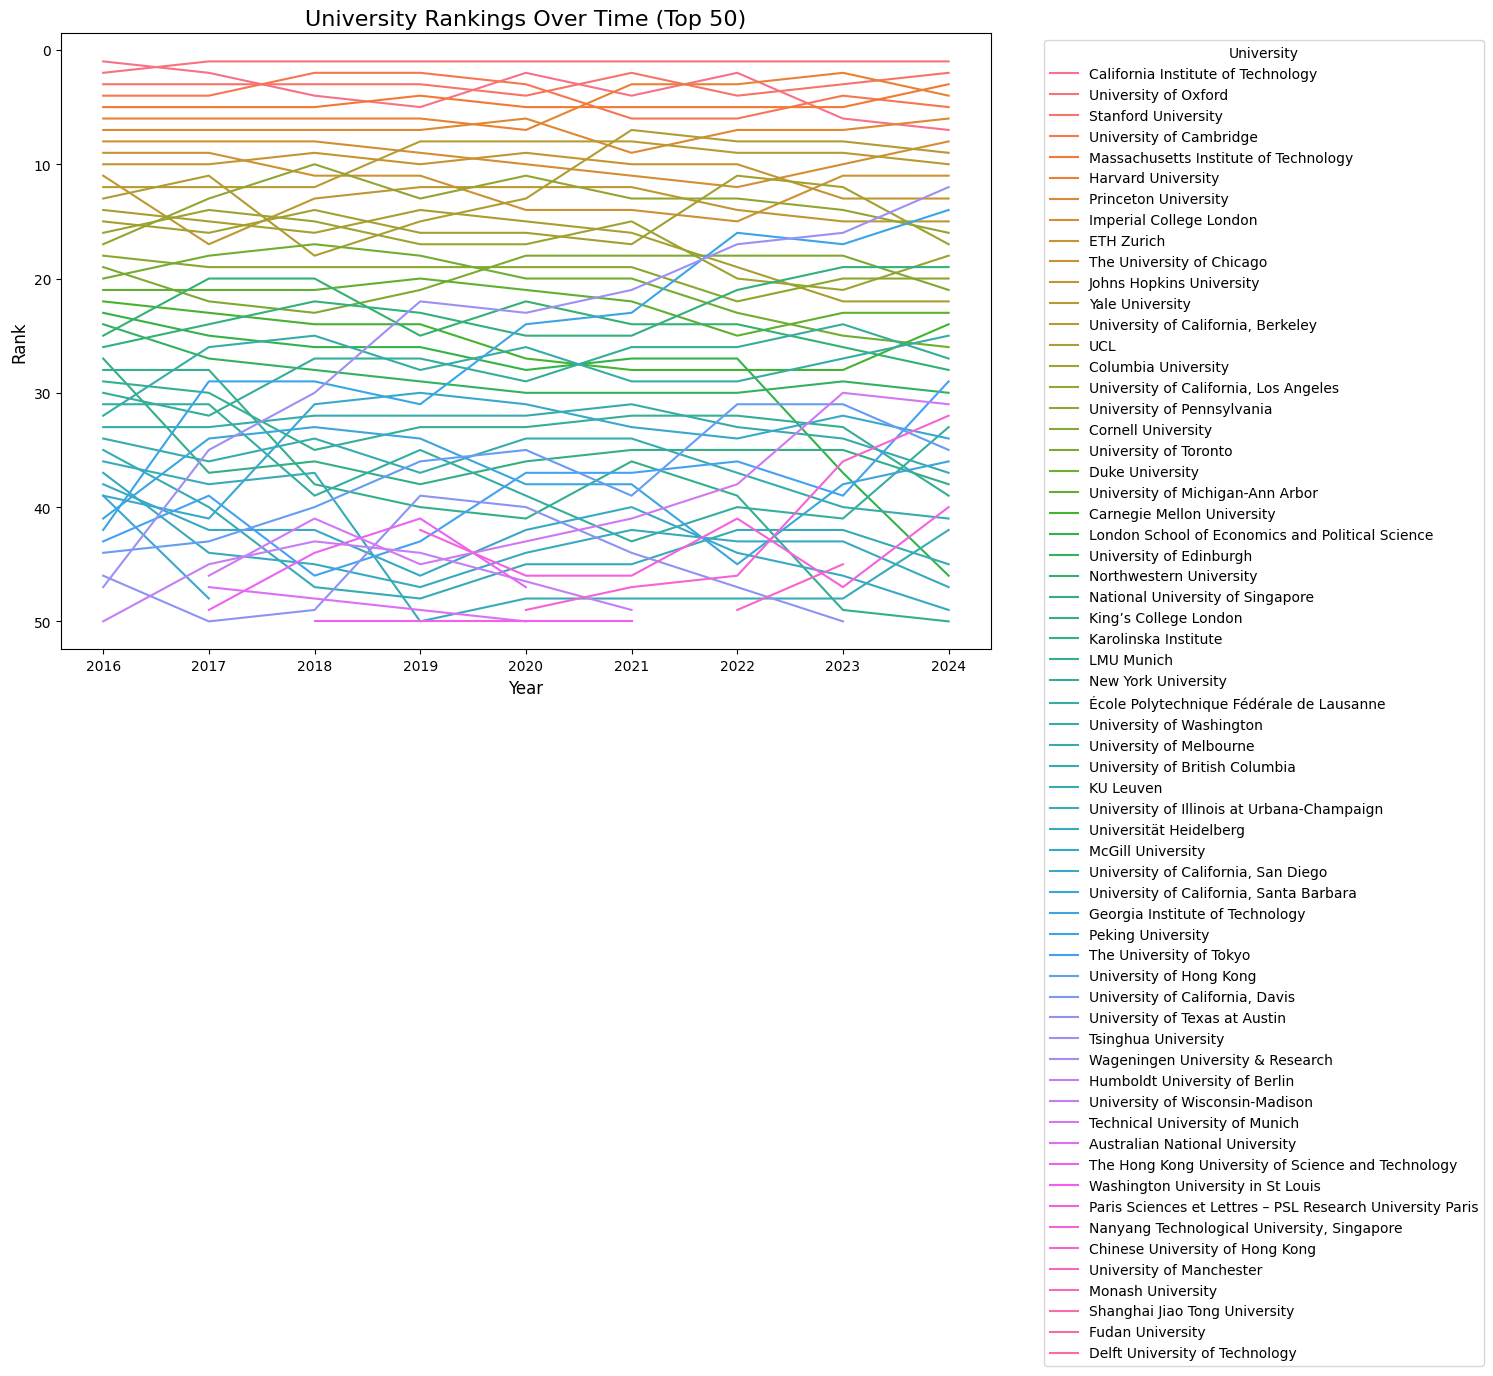

In [4]:
# displaying top 50 universities from 20
top50 = df.copy()
top50 = top50[top50['Rank'] <= 50]
top50 = top50[top50['Year'] != 2025]

plt.figure(figsize=(12, 8))
sns.lineplot(data=top50, x='Year', y='Rank', hue='Name', linewidth=1.5)
plt.gca().invert_yaxis()
plt.title("University Rankings Over Time (Top 50)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='University')
plt.show()

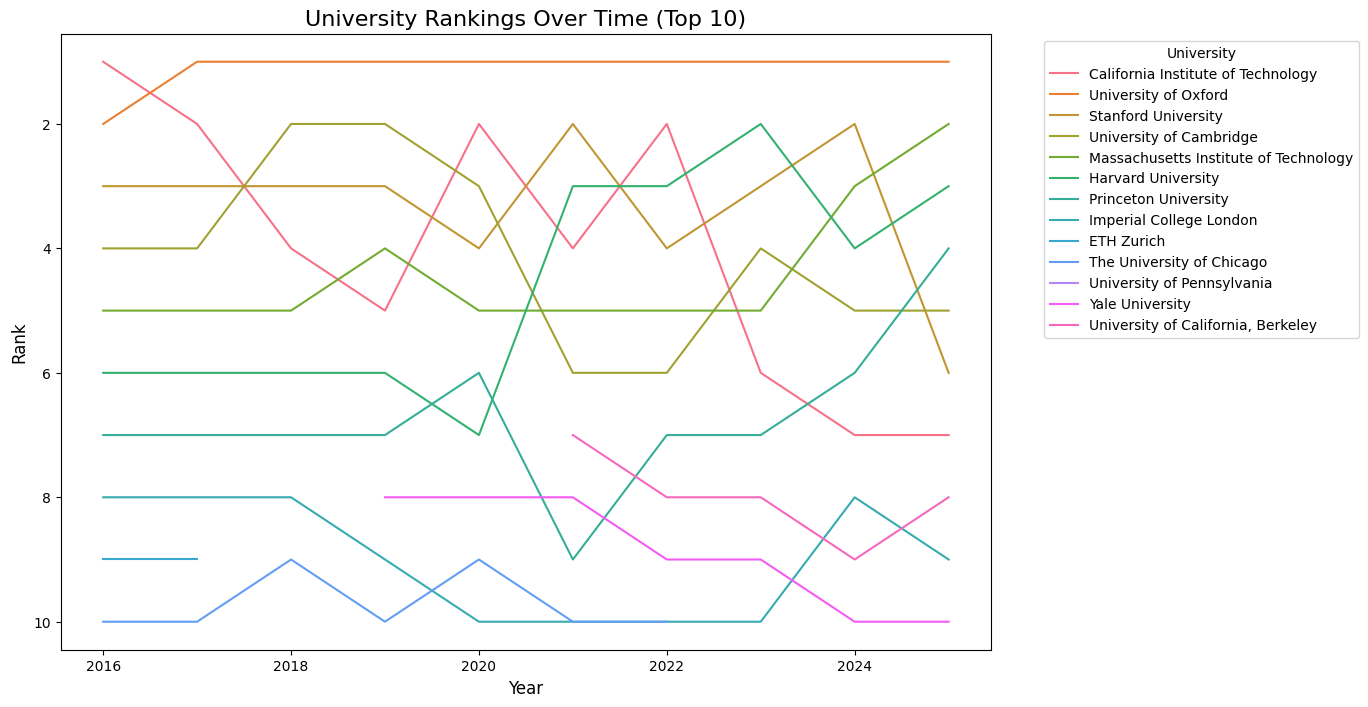

In [5]:
top10 = df.copy()
top10 = top10[top10['Rank'] <= 10]
plt.figure(figsize=(12, 8))
sns.lineplot(data=top10, x='Year', y='Rank', hue='Name', linewidth=1.5)
plt.gca().invert_yaxis()
plt.title("University Rankings Over Time (Top 10)", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='University')
plt.show()

## Which country / continent / university stands out?

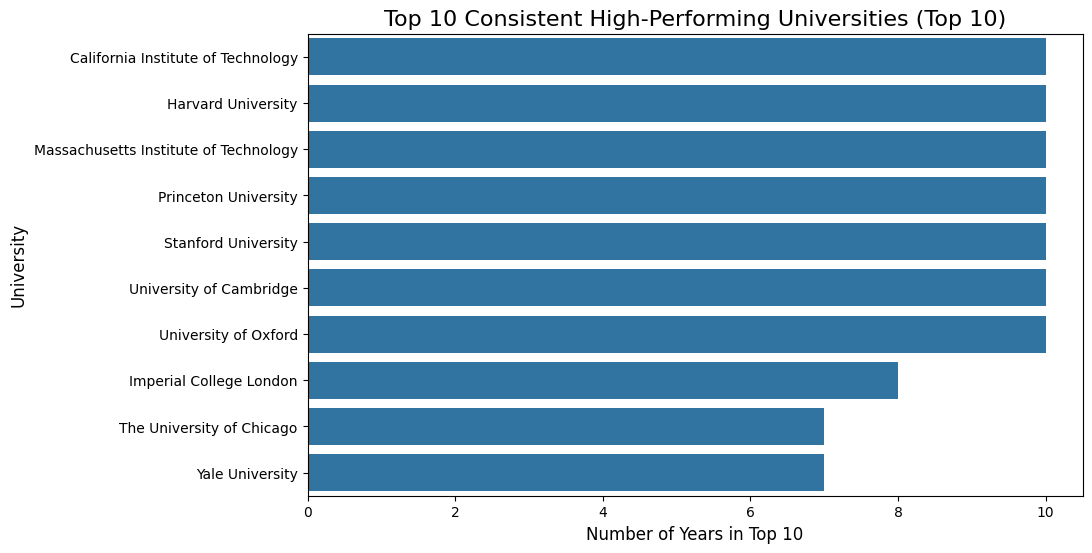

In [6]:
# highlight the universities that seem to perform really well consecutively
consistent_performers = (
    top10.groupby('Name')['Year']
    .count()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=consistent_performers.values, y=consistent_performers.index)
plt.title("Top 10 Consistent High-Performing Universities (Top 10)", fontsize=16)
plt.xlabel("Number of Years in Top 10", fontsize=12)
plt.ylabel("University", fontsize=12)
plt.show()


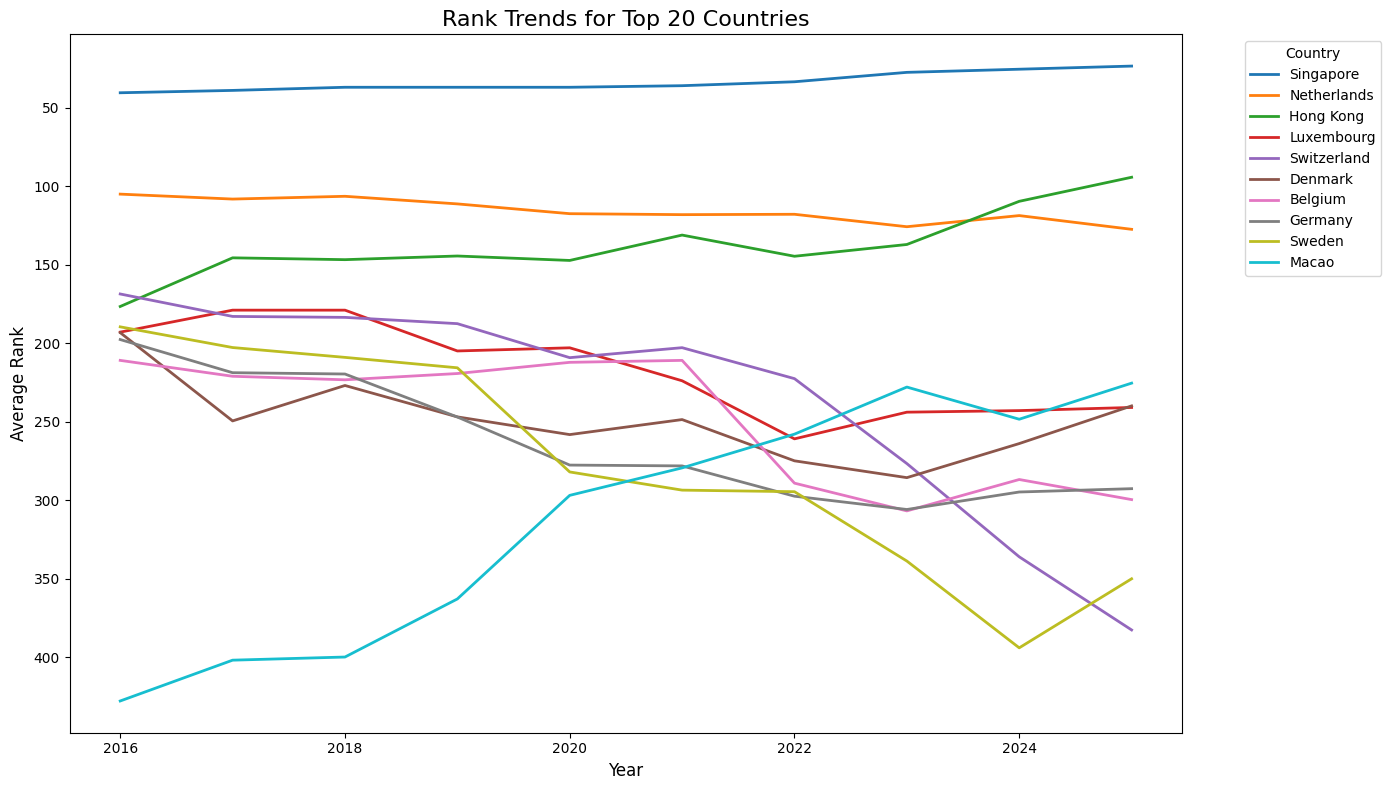

In [7]:

df_copy6 = df.copy()

df_copy6 = df_copy6.dropna(subset=['Rank', 'Year', 'Country'])

country_avg_rank_all_years = df_copy6.groupby('Country')['Rank'].mean().reset_index()

top_10_countries = country_avg_rank_all_years.sort_values('Rank').head(10)['Country']

df_copy6_top_10 = df_copy6[df_copy6['Country'].isin(top_10_countries)]

plt.figure(figsize=(14, 8))

for country in top_10_countries:
    country_data = df_copy6_top_10[df_copy6_top_10['Country'] == country]
    country_avg_rank = country_data.groupby('Year')['Rank'].mean().reset_index()

    sns.lineplot(
        data=country_avg_rank,
        x='Year',
        y='Rank',
        lw=2,
        label=country
    )

plt.title("Rank Trends for Top 20 Countries", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Rank", fontsize=12)
plt.gca().invert_yaxis()
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


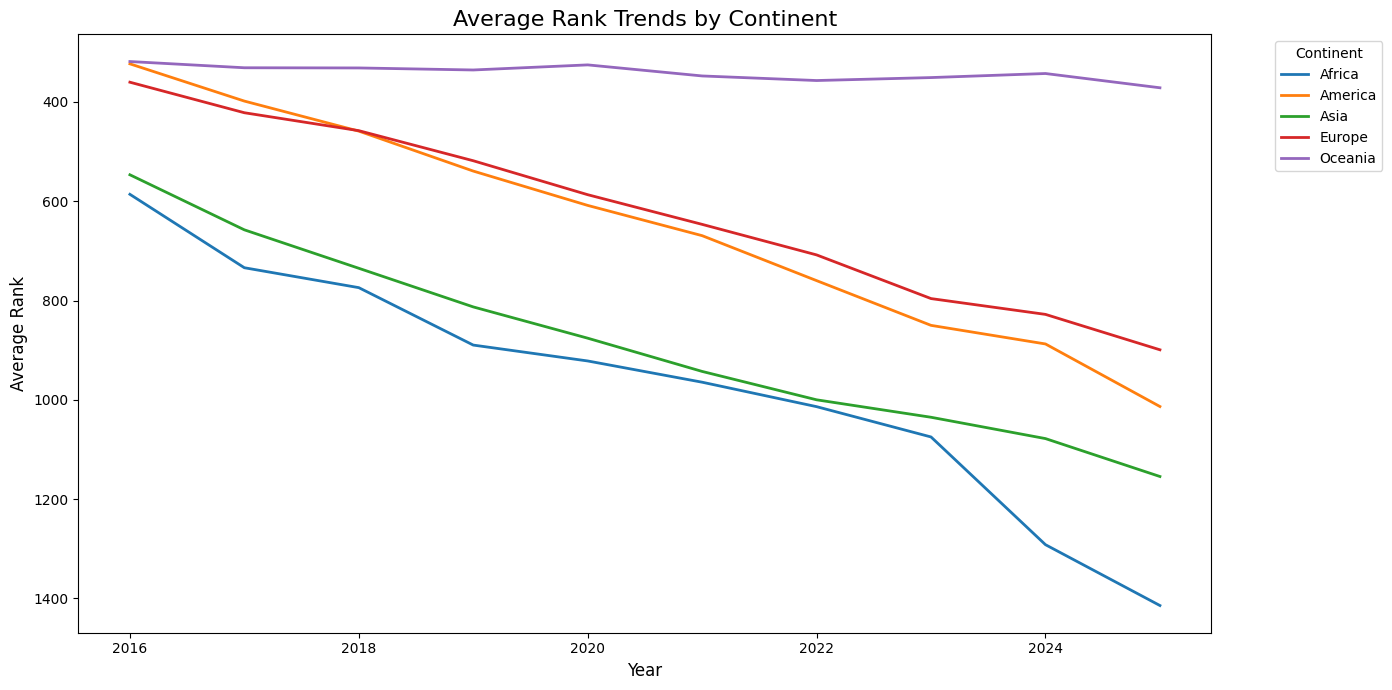

In [8]:

df_copy6 = df_copy6.dropna(subset=['Rank', 'Year', 'Continent'])
continent_avg_rank = df_copy6.groupby(['Year', 'Continent'])['Rank'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=continent_avg_rank,
    x='Year',
    y='Rank',
    hue='Continent',
    lw=2
)
plt.title("Average Rank Trends by Continent", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Average Rank", fontsize=12)
plt.gca().invert_yaxis()
plt.legend(title='Continent', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### looking at the jumps or drops in ranking of universities from one year to the next:

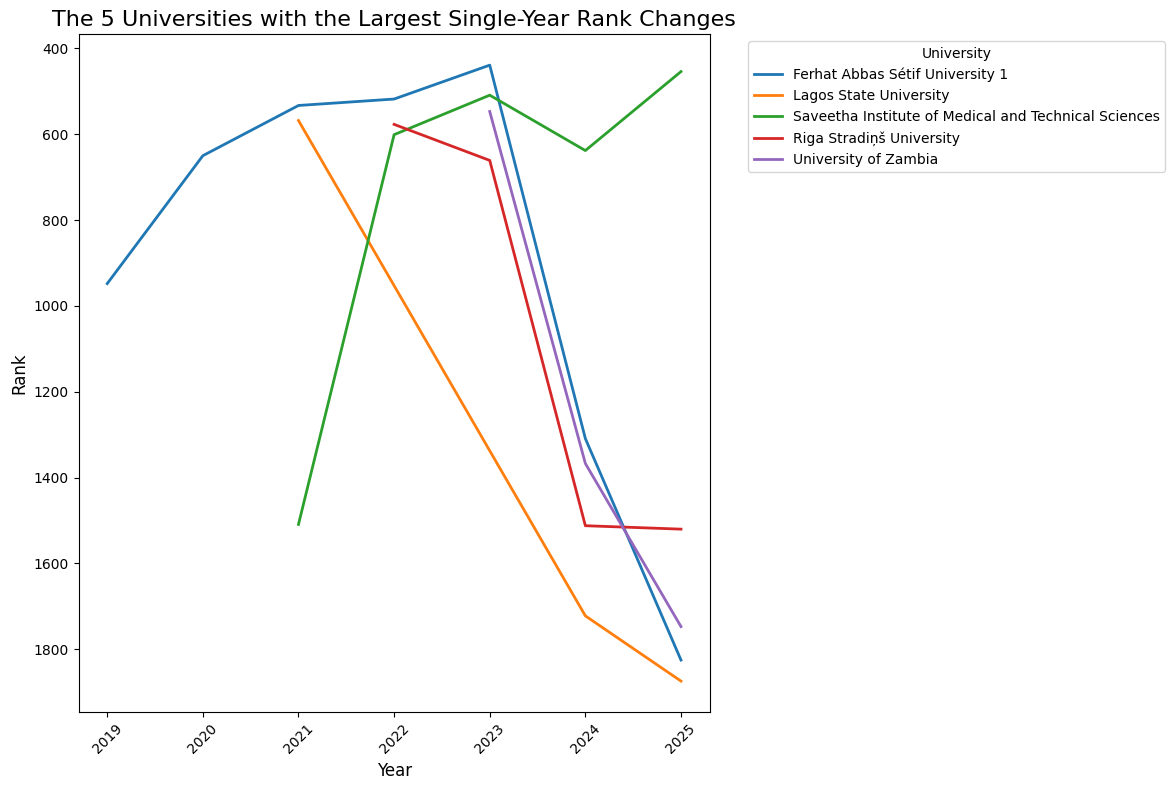

In [9]:
# Calculate year-over-year changes in rank

df_copy3 = df.copy()

df_copy3['Rank Change'] = df_copy3.groupby('Name')['Rank'].diff()

valid_groups = df_copy3.groupby('Name').filter(lambda group: group['Rank Change'].notna().any())

largest_jumps = valid_groups.loc[
    valid_groups.groupby('Name')['Rank Change'].apply(lambda x: x.dropna().abs().idxmax())
]

largest_jumps = largest_jumps.reset_index()
top_jumps = largest_jumps.loc[largest_jumps['Rank Change'].abs().nlargest(5).index]

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=valid_groups[valid_groups['Name'].isin(top_jumps['Name'])],
    x='Year',
    y='Rank',
    hue='Name',
    markers=True,
    dashes=False,
    linewidth=2
)
plt.gca().invert_yaxis()
plt.title("The 5 Universities with the Largest Single-Year Rank Changes", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Rank", fontsize=12)
plt.legend(title='University', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


## Which fields dominate in each year?

In [10]:
df_copy = df.copy()
fields_of_study = ['Teaching', 'Research Environment', 'Research Quality', 'Industry Impact', 'International Outlook']

top_universities_by_field = {}
aggregated_df = df_copy.groupby('Name')[fields_of_study].mean().reset_index()

for field in fields_of_study:
    top_universities = (
        aggregated_df[['Name', field]]
        .sort_values(by=field, ascending=False)
        .head(3)
    )
    top_universities_by_field[field] = top_universities

for field, top_universities in top_universities_by_field.items():
    print(f"\nTop 3 Universities in {field} (Aggregated Over All Years):\n")
    print(top_universities)



Top 3 Universities in Teaching (Aggregated Over All Years):

                                       Name  Teaching
192      California Institute of Technology     93.68
1320                    Stanford University     93.58
825   Massachusetts Institute of Technology     91.95

Top 3 Universities in Research Environment (Aggregated Over All Years):

                         Name  Research Environment
1953     University of Oxford                 99.55
490        Harvard University                 98.92
1684  University of Cambridge                 98.73

Top 3 Universities in Research Quality (Aggregated Over All Years):

                                       Name  Research Quality
1320                    Stanford University             99.83
825   Massachusetts Institute of Technology             99.76
490                      Harvard University             99.45

Top 3 Universities in Industry Impact (Aggregated Over All Years):

                                                   Na

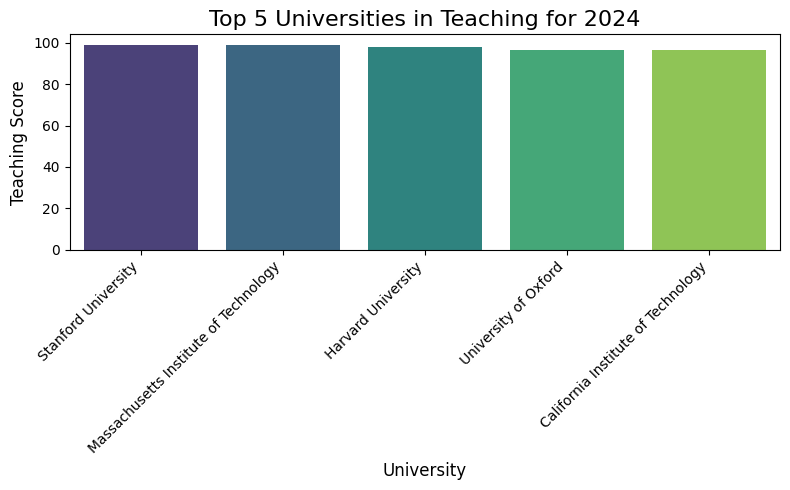

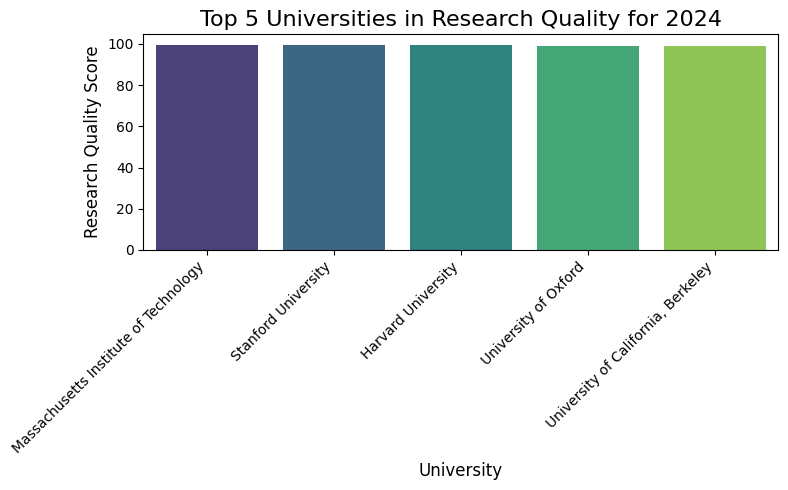

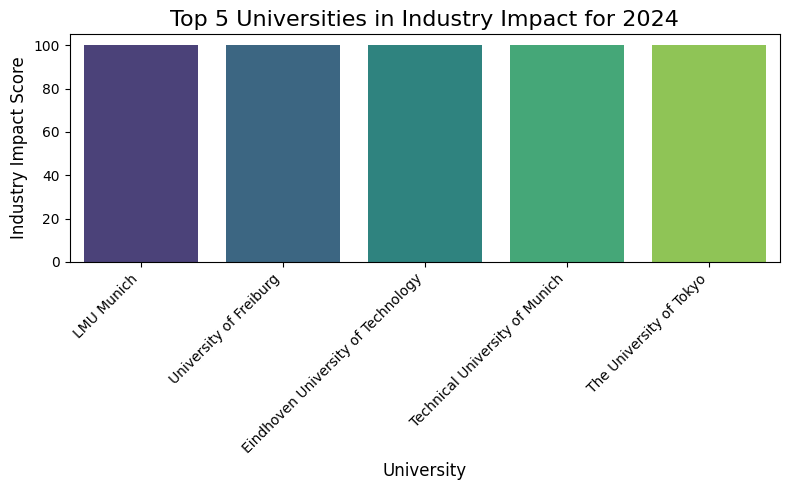

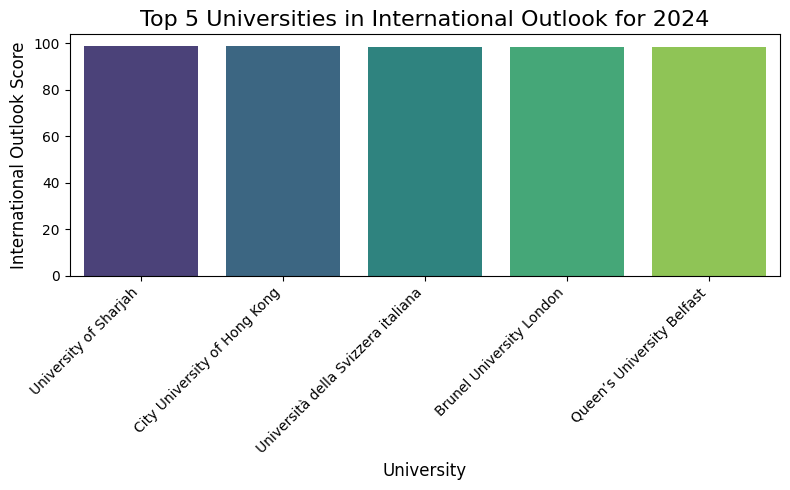

In [11]:
df_copy = df.copy()
fields_of_study = ['Teaching', 'Research Quality', 'Industry Impact', 'International Outlook']
df_2024 = df_copy[df_copy['Year'] == 2024]

top_universities_by_field_2024 = {}

for field in fields_of_study:
    top_universities = (
        df_2024[['Name', field]]
        .sort_values(by=field, ascending=False)
        .head(5)
    )
    top_universities_by_field_2024[field] = top_universities

for field, top_universities in top_universities_by_field_2024.items():
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=top_universities,
        y=field,
        x='Name',
        palette='viridis',
        hue='Name',
        legend=False
    )
    plt.title(f"Top 5 Universities in {field} for 2024", fontsize=16)
    plt.xlabel("University", fontsize=12)
    plt.ylabel(f"{field} Score", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Question 2: Which characteristics of universities contribute most to good rankings, or to large changes in the ranking position?

## Calculate changes in rank for universities over the years

In [12]:
def calculate_rank_change(df):
    df = df.sort_values(by=["Name", "Year"])  # Ensure sorting
    df["Rank Change"] = df.groupby("Name")["Rank"].diff()
    return df

df = calculate_rank_change(df)
 

# Analyze correlation of features with Rank


Correlation with Rank:
Rank                       1.000000
GII                        0.384940
Year                       0.379689
Population                 0.051459
Student Population         0.005922
Female to Male Ratio       0.005686
Students to Staff Ratio    0.004559
GDP                       -0.253212
CO2                       -0.356841
HDI                       -0.473000
International Students    -0.492039
Industry Impact           -0.498642
Corruption                -0.531019
International Outlook     -0.579548
Teaching                  -0.643042
Research Environment      -0.710603
Research Quality          -0.807047
Overall Score             -0.848774
Name: Rank, dtype: float64


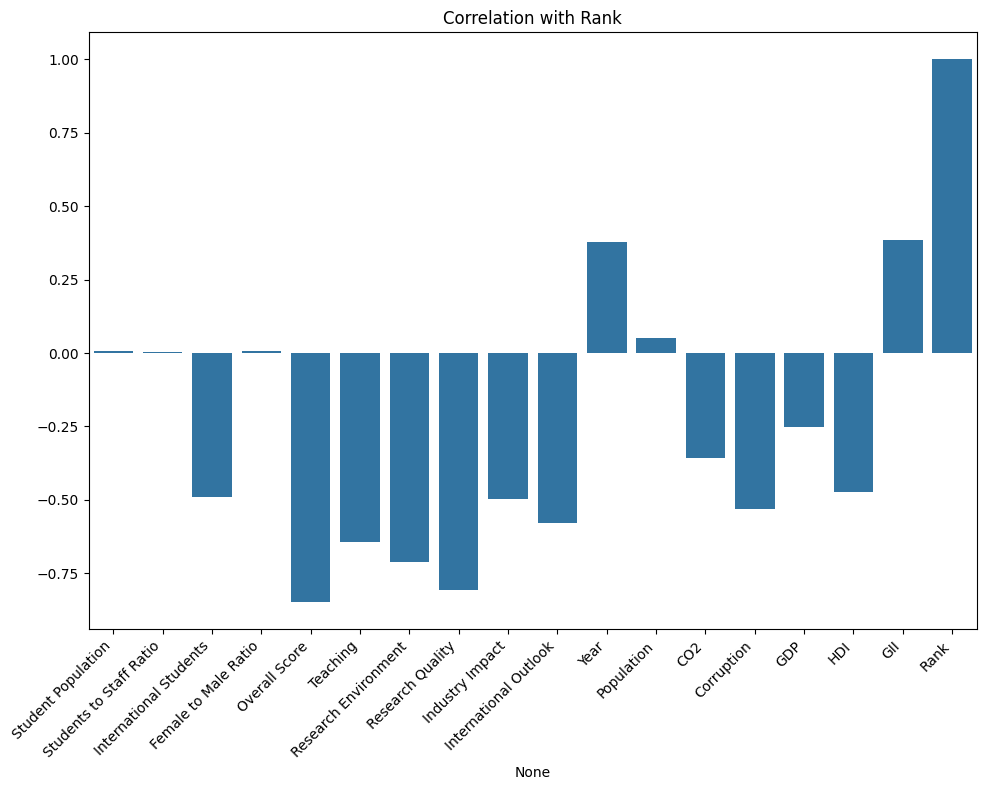

In [13]:
def correlation_with_rank(df):
   
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude targets
    numeric_columns = [col for col in numeric_columns if col not in ["Rank", "Rank Change"]]  

    correlation = df[numeric_columns + ["Rank"]].corr()["Rank"]
    print("\nCorrelation with Rank:")
    print(correlation.sort_values(ascending=False))

    plt.figure(figsize=(10, 8))
    sns.barplot(x=correlation.index, y=correlation.values)
    plt.xticks(rotation=45, ha='right')
    plt.title("Correlation with Rank")
    plt.tight_layout()
    plt.show()

correlation_with_rank(df)

# Determine feature importance for predicting Rank without Overall Score

Mean Squared Error for Rank Prediction (Excluding Overall Score): 1394.987490361446


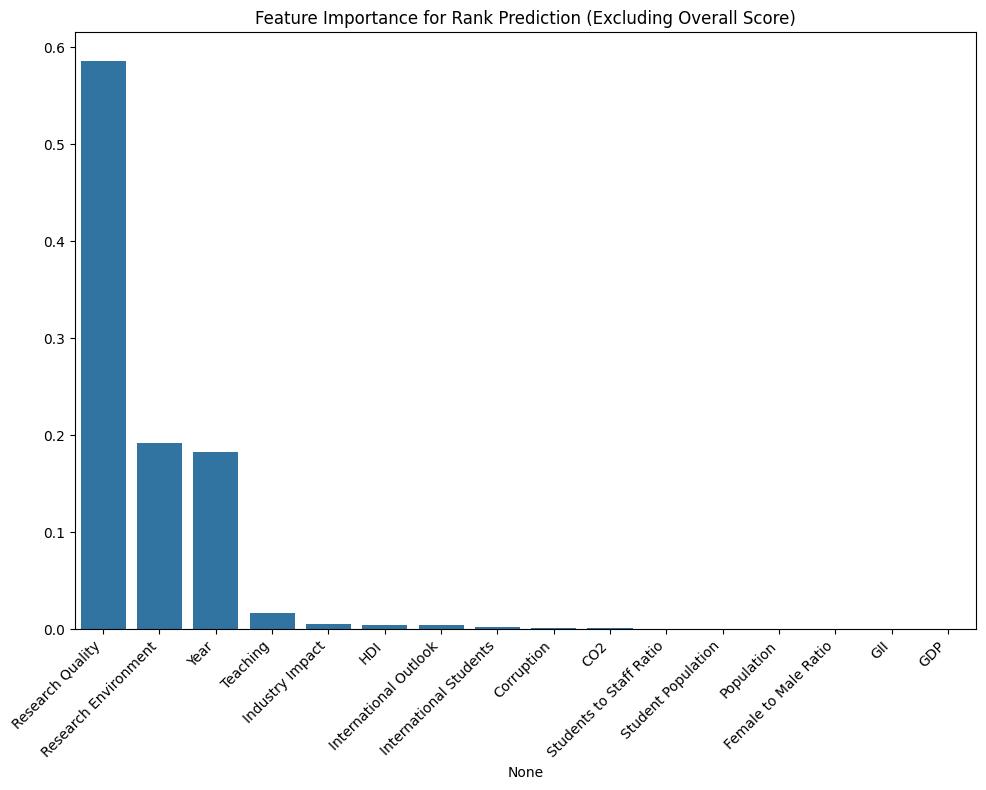

In [14]:
def feature_importance(df):
    features = df.select_dtypes(include=[np.number]).drop(columns=["Rank", "Rank Change", "Overall Score"]).columns
    X = df[features].fillna(0)  
    y = df["Rank"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error for Rank Prediction (Excluding Overall Score): {mse}")

    # Plot feature importance
    importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importance.index, y=importance.values)
    plt.xticks(rotation=45, ha='right')
    plt.title("Feature Importance for Rank Prediction (Excluding Overall Score)")
    plt.tight_layout()
    plt.show()

feature_importance(df)

# Analyze feature differences for top improvers and decliners 


Top Improvers:
                                                    Name  Year    Rank  \
7665   Saveetha Institute of Medical and Technical Sc...  2022   601.0   
6113                               Sumy State University  2021   575.0   
13571                                   Inönü University  2025  1142.0   
9374                                     Taif University  2023   648.0   
11220                   The Catholic University of Korea  2024   695.0   
6023            Bauman Moscow State Technical University  2021   485.0   
9437   National Yunlin University of Science and Tech...  2023   711.0   
11102                          Pusan National University  2024   577.0   
11578                                 Akdeniz University  2024  1053.0   
7743                          Wenzhou Medical University  2022   679.0   

       Rank Change  
7665        -908.0  
6113        -639.0  
13571       -621.0  
9374        -586.0  
11220       -565.0  
6023        -467.0  
9437        -462.0  
1

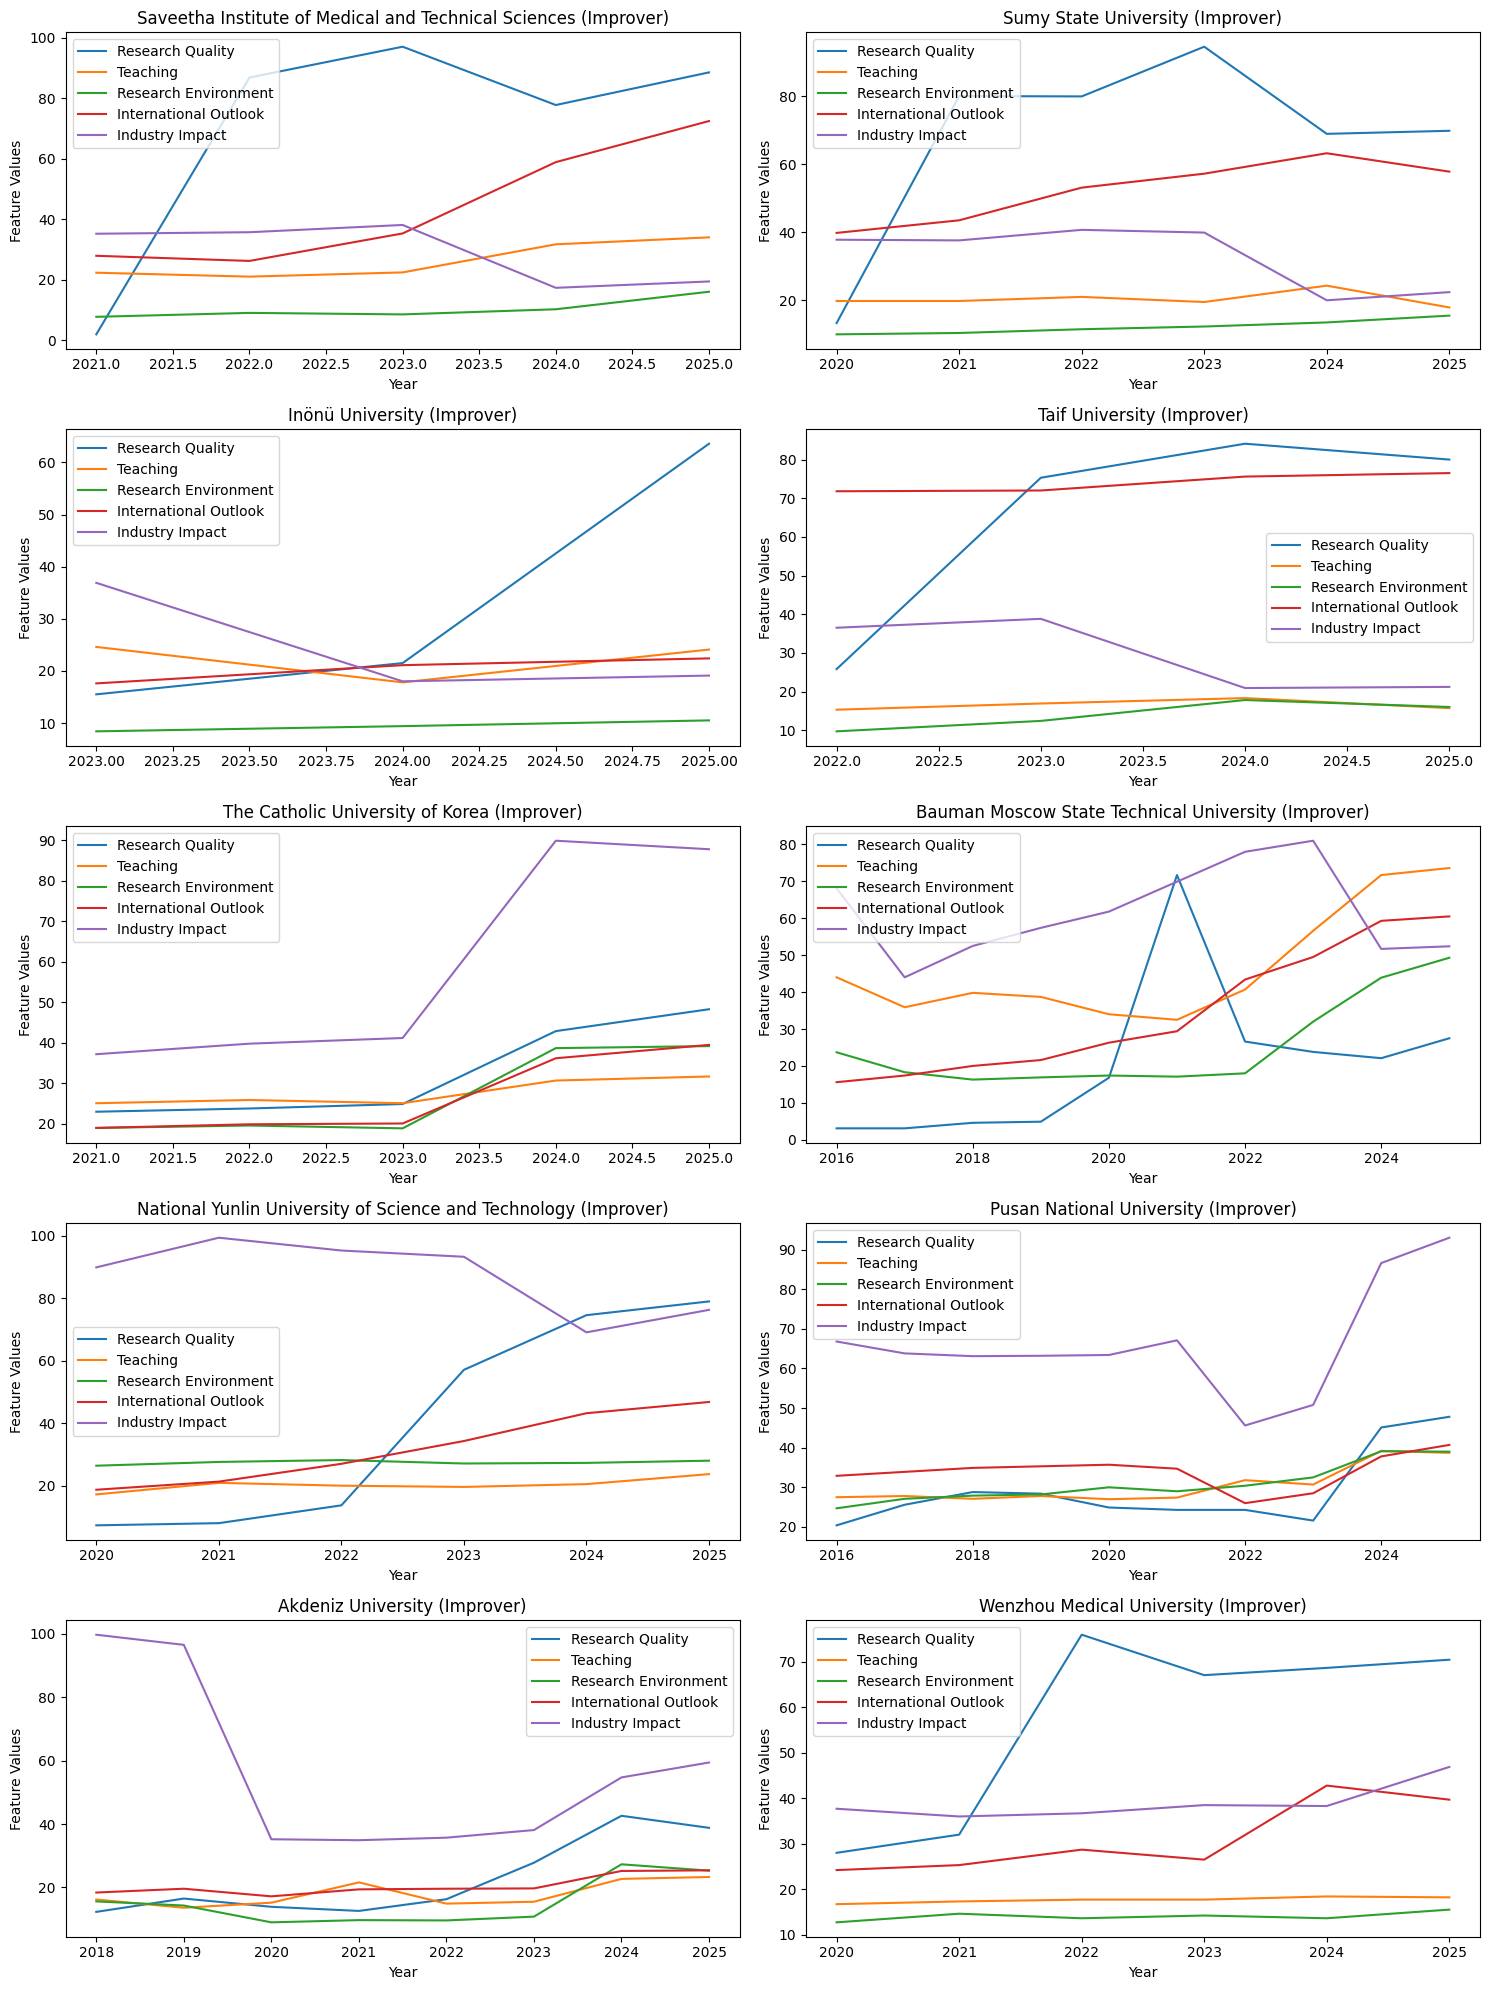

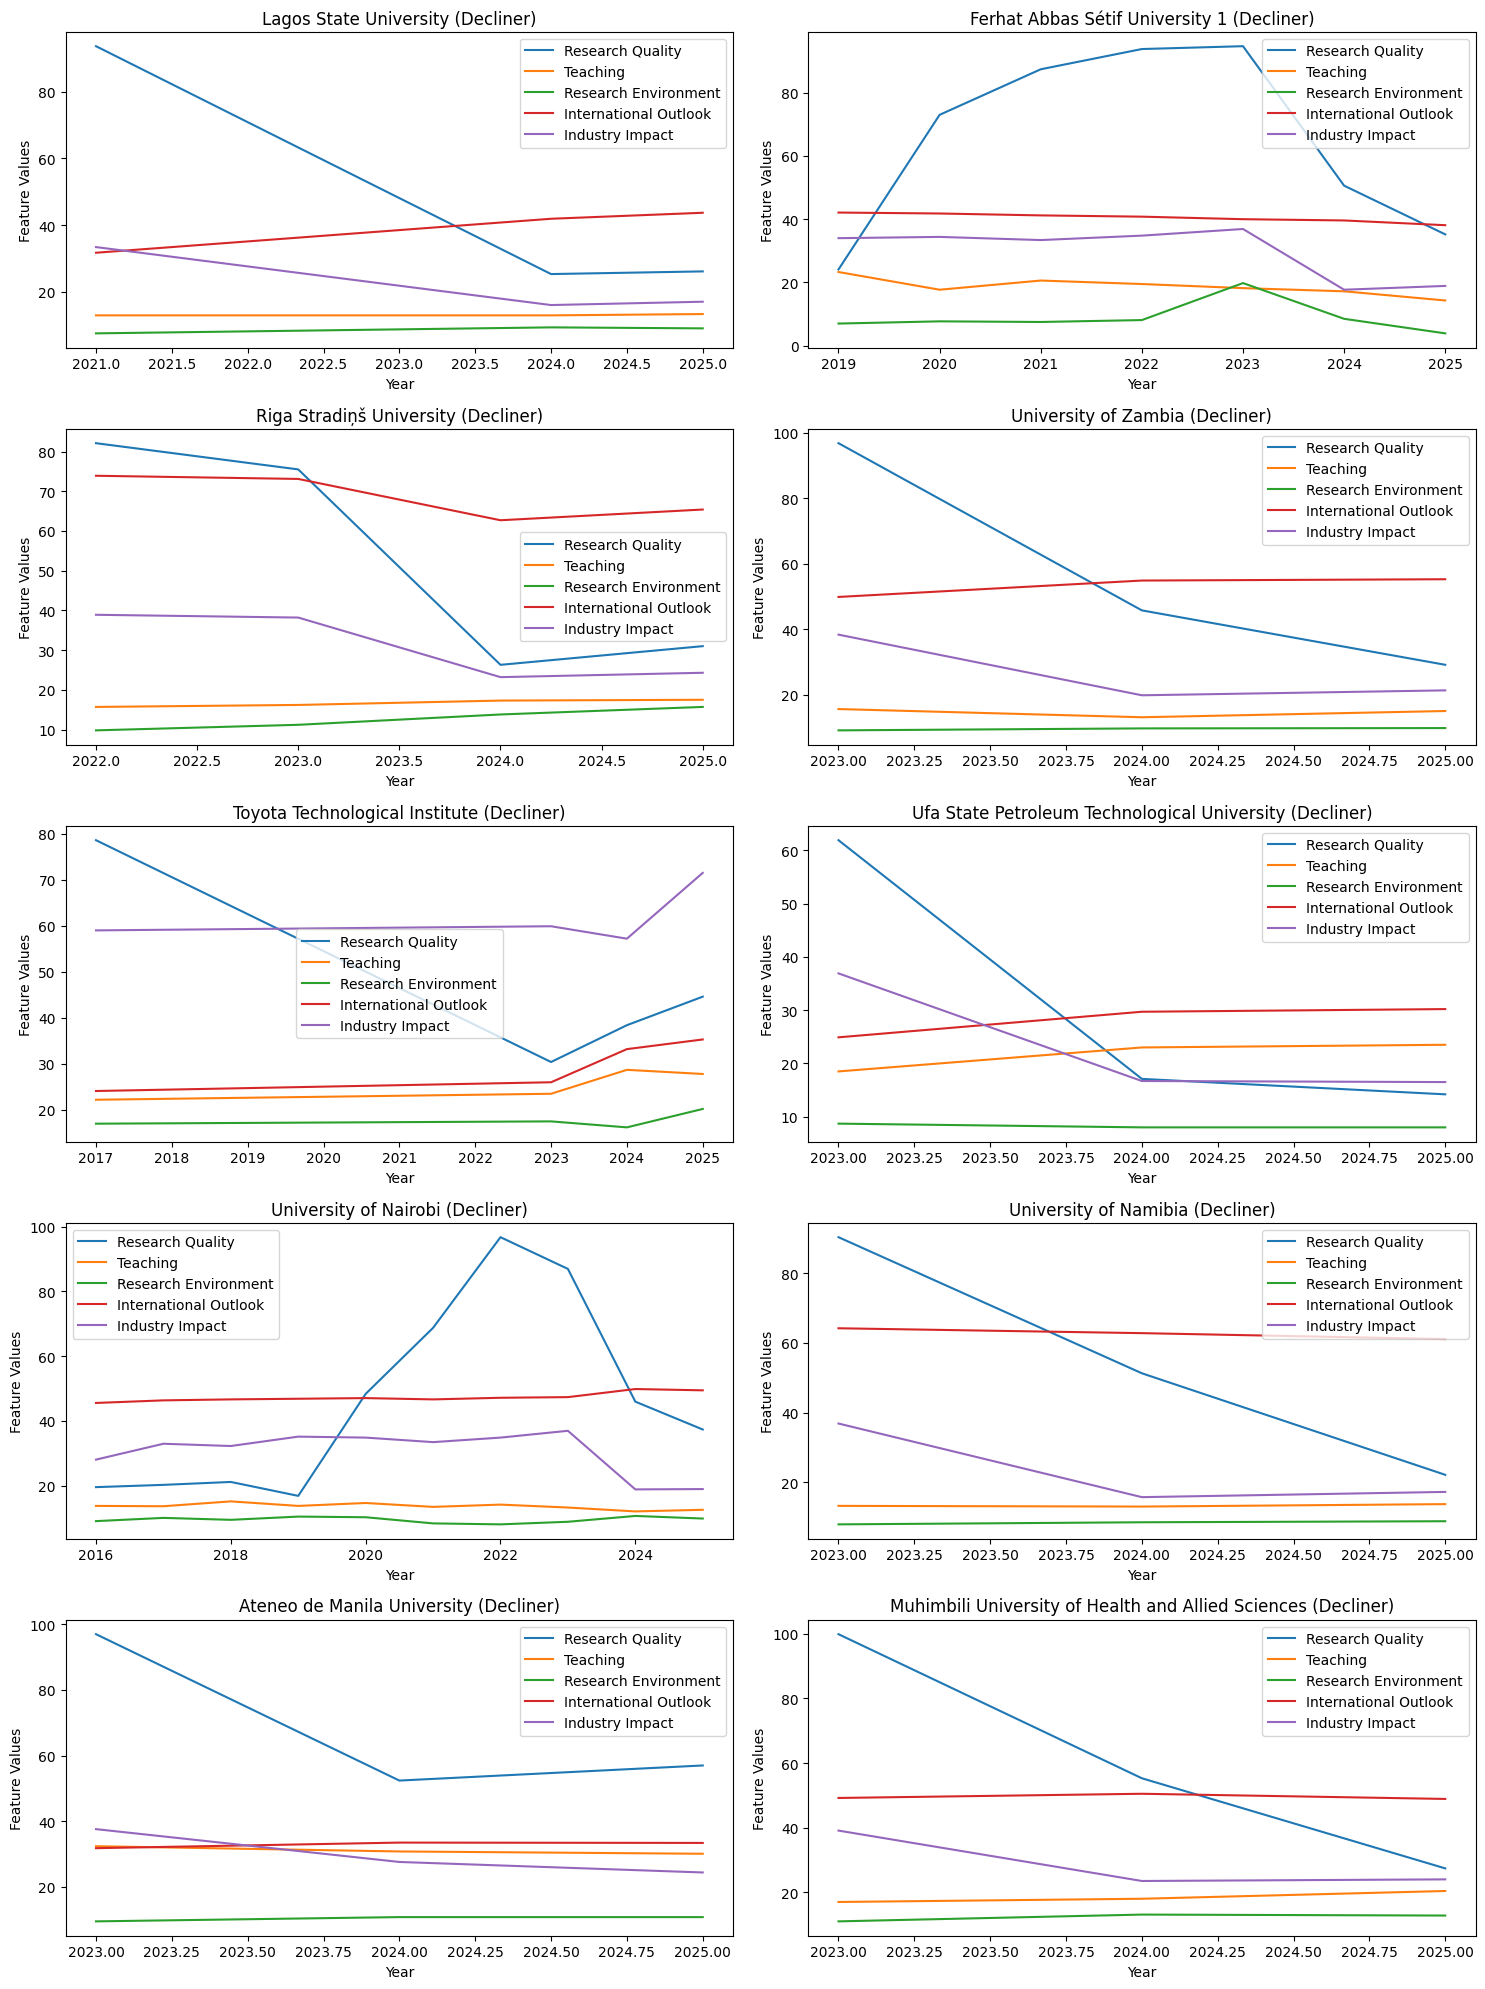

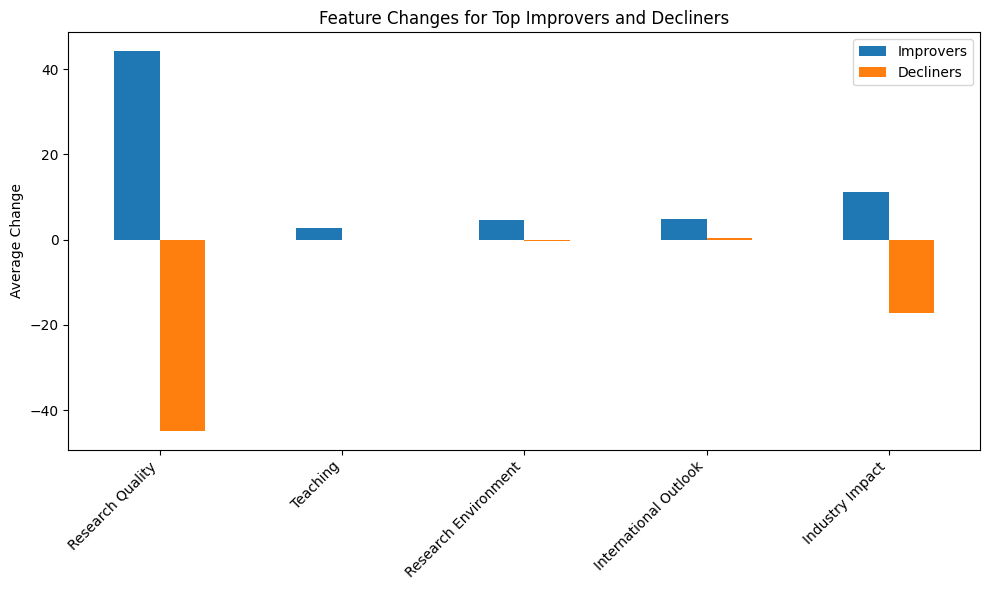

In [15]:
def investigate_top_movers(df):
    
    df_top_movers = df[~df["Rank Change"].isnull()]  

    # Identify top improvers and decliners
    top_improvers = df_top_movers.nsmallest(10, "Rank Change")  
    top_decliners = df_top_movers.nlargest(10, "Rank Change")  

    # Output Top Movers
    print("\nTop Improvers:")
    print(top_improvers[["Name", "Year", "Rank", "Rank Change"]])

    print("\nTop Decliners:")
    print(top_decliners[["Name", "Year", "Rank", "Rank Change"]])

    # Define key features for comparison
    key_features = ["Research Quality", "Teaching", "Research Environment", "International Outlook", "Industry Impact"]

    # Visualize Feature Changes for Improvers
    fig, axes = plt.subplots(5, 2, figsize=(15, 20))
    axes = axes.flatten()
    for i, (index, row) in enumerate(top_improvers.iterrows()):
        name = row["Name"]
        university_data = df[df["Name"] == name].sort_values("Year")
        university_data[key_features + ["Year"]].set_index("Year").plot(ax=axes[i])
        axes[i].set_title(f"{name} (Improver)")
        axes[i].set_ylabel("Feature Values")
        axes[i].set_xlabel("Year")
    plt.tight_layout()
    plt.show()

    # Visualize Feature Changes for Decliners 
    fig, axes = plt.subplots(5, 2, figsize=(15, 20))
    axes = axes.flatten()
    for i, (index, row) in enumerate(top_decliners.iterrows()):
        name = row["Name"]
        university_data = df[df["Name"] == name].sort_values("Year")
        university_data[key_features + ["Year"]].set_index("Year").plot(ax=axes[i])
        axes[i].set_title(f"{name} (Decliner)")
        axes[i].set_ylabel("Feature Values")
        axes[i].set_xlabel("Year")
    plt.tight_layout()
    plt.show()

    # Grouped Bar Plot for Improvers and Decliners
    improvers_stats = []
    decliners_stats = []
    for index, row in top_improvers.iterrows():
        name = row["Name"]
        year = row["Year"]
        previous_year = df[(df["Name"] == name) & (df["Year"] == year - 1)]
        if not previous_year.empty:
            diff = row[key_features] - previous_year[key_features].iloc[0]
            improvers_stats.append(diff)

    for index, row in top_decliners.iterrows():
        name = row["Name"]
        year = row["Year"]
        previous_year = df[(df["Name"] == name) & (df["Year"] == year - 1)]
        if not previous_year.empty:
            diff = row[key_features] - previous_year[key_features].iloc[0]
            decliners_stats.append(diff)

    improvers_stats = pd.DataFrame(improvers_stats, columns=key_features)
    decliners_stats = pd.DataFrame(decliners_stats, columns=key_features)

    improvers_mean = improvers_stats.mean()
    decliners_mean = decliners_stats.mean()
    df_changes = pd.DataFrame({"Improvers": improvers_mean, "Decliners": decliners_mean})

    df_changes.plot(kind="bar", figsize=(10, 6))
    plt.title("Feature Changes for Top Improvers and Decliners")
    plt.ylabel("Average Change")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

investigate_top_movers(df)

# Question 4: Are there predictors for increases or decreases in the rankings? Which predictors are significant in a model? How do such models perform
In this step, we load and prepare our combined dataset to fit different regression models. The models used are Lasso, Ridge and Gradient Boosting. The decision of which model to choose was based on our research, but mainly follows the guideline of scikit learn (https://scikit-learn.org/1.6/machine_learning_map.html). In a first test, LinearSVC was used instead of Ridge, but due to it's extremely bad performance, we instead opted to use a different model for our experiments.

## Load and prepare data
In order to prevent data leakage, we load and immediately split the data in train, validation and test sets. The train and validation sets will be used to train the models and optimize their hyperparameters, while the test set is used in a last step to evaluate the performance. 

We chose to drop multiple columns that have no predictive power like Name and Year from our feature sets. We also chose to remove the Overall Score, since the rank of universities in the original dataset is based on this score, as well as the country column, which we replaced with the column continent.

In [16]:
df = pd.read_csv("universities.csv")

df_train, df_test = train_test_split(df, test_size=0.2, random_state=random_state)

target_column = "Rank"
X = df_train.drop(columns=[target_column, "Overall Score", "Name", "Year", "Country"])
y = df_train[target_column]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)  

X_train.isna().sum()/X_train.shape[0]

X_test = df_test.drop(columns=[target_column, "Overall Score", "Name", "Year", "Country"])
y_test = df_test[target_column] 

### Encoding Continent column
Since the continent column is a nominal column, we need to encode it into a numerical representation before training the model. This is done by using one hot encoding. In this case, one hot encoding only introduces four new columns, which should not pose any great challenge to efficiency.

In [17]:
enc = OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore")
encoded_X_train = enc.fit_transform(X_train[["Continent"]])
col_names = enc.get_feature_names_out(input_features=["Continent"])

encoded_X_train = pd.DataFrame(encoded_X_train, columns=col_names, index=X_train.index)
X_train = pd.concat([X_train.drop(columns=["Continent"]), encoded_X_train], axis=1)

encoded_X_valid = enc.transform(X_valid[["Continent"]])
encoded_X_valid = pd.DataFrame(encoded_X_valid, columns=col_names, index=X_valid.index)
X_valid = pd.concat([X_valid.drop(columns=["Continent"]), encoded_X_valid], axis=1)

encoded_X_test = enc.transform(X_test[["Continent"]])
encoded_X_test = pd.DataFrame(encoded_X_test, columns=col_names, index=X_test.index)
X_test = pd.concat([X_test.drop(columns=["Continent"]), encoded_X_test], axis=1)

### Handling missing values
As we can see in the next code block, there are multiple columns with missing values. Furthermore, most of these columns have a very large ration of missing values (> 30%). This certainly poses a challenge to our regression task. We tried out two different methods of dealing with missing values. Option one is imputing the missing values using the mean. Option two is deleting sparse columns entirely. Our experiments showed that Gradient Boosting profited greatly from imputing, while Lasso and Ridge had extremly worse results when missing values where imputed (R^2 sky rocketed from 10^5 to 10^23). In the end, we chose to go with option 2 to avoid these extremely large losses for Lasso and Ridge.

In [18]:
print(X_train.isna().sum()/X_train.shape[0])

Student Population         0.000000
Students to Staff Ratio    0.000000
International Students     0.000000
Female to Male Ratio       0.049069
Teaching                   0.000000
Research Environment       0.000000
Research Quality           0.000000
Industry Impact            0.000000
International Outlook      0.000000
Population                 0.306898
CO2                        0.307113
Corruption                 0.373507
GDP                        0.460454
HDI                        0.441408
GII                        0.444205
Continent_Africa           0.000000
Continent_America          0.000000
Continent_Asia             0.000000
Continent_Europe           0.000000
Continent_Oceania          0.000000
dtype: float64


#### Option 1: Imputing missing values

In [19]:
%%script false

imputer = SimpleImputer(strategy="mean")
X_train[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]] = imputer.fit_transform(X_train[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]])
X_valid[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]] = imputer.transform(X_valid[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]])
X_test[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]] = imputer.transform(X_test[["Female to Male Ratio", "Population", "CO2", "Corruption", "GDP", "HDI", "GII"]])

print("Missing values left:")
print(X_train.isna().all().any())

Couldn't find program: 'false'


#### Option 2: Removing sparse columns

In [20]:

imputer = SimpleImputer(strategy="mean")
X_train[["Female to Male Ratio"]] = imputer.fit_transform(X_train[["Female to Male Ratio"]])
X_valid[["Female to Male Ratio"]] = imputer.transform(X_valid[["Female to Male Ratio"]])
X_test[["Female to Male Ratio"]] = imputer.transform(X_test[["Female to Male Ratio"]])

def remove_sparse_cols(df, sparse_cols):
    df = df.drop(columns=sparse_cols)
    return df
    
X_train = remove_sparse_cols(X_train, ["Population", "CO2", "Corruption", "GDP", "HDI", "GII"])
X_valid = remove_sparse_cols(X_valid, ["Population", "CO2", "Corruption", "GDP", "HDI", "GII"])
X_test = remove_sparse_cols(X_test, ["Population", "CO2", "Corruption", "GDP", "HDI", "GII"])

print("Missing values left:")
print(X_train.isna().all().any())

Missing values left:
False


## Models & GridSearch
We use Grid Search for each model to test a few hyperparameter settings. Here, we also provide methods to evaluate the model and look at the most significant features in Lasso and Ridge

In [21]:
def grid_search(regressor, param_grid, X_train, y_train, X_valid, y_valid, cv: int = 5):
    scoring = {
        "R2": make_scorer(r2_score),
        "RMSE": make_scorer(root_mean_squared_error)
    }
    
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", regressor)
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        refit="R2",
        cv=cv,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    train_rmse = root_mean_squared_error(y_train, best_model.predict(X_train))
    valid_r2 = r2_score(y_valid, best_model.predict(X_valid))
    valid_rmse = root_mean_squared_error(y_valid, best_model.predict(X_valid))
    
    results = {
        "train_r2": train_r2,
        "train_rmse": train_rmse,
        "valid_r2": valid_r2,
        "valid_rmse": valid_rmse
    }
    
    return best_model, best_params, results


In [22]:
def evaluate_model(model, X_train, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    test_r2 = r2_score(y_test, y_pred)
    test_rmse = root_mean_squared_error(y_test, y_pred)
    
    residuals = y_test - y_pred
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.title(f"{model_name} Residual Plot")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
    plt.title(f"{model_name} Parity Plot")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.grid()

    plt.tight_layout()
    plt.savefig(f"results/{model_name}_eval")
    plt.close("all")
    
    return test_r2, test_rmse

In [23]:
def show_coefs_and_eval_pipeline(best_model_pipeline, X_train, X_test, y_test, model_name):
    model = best_model_pipeline.named_steps["regressor"]
    coefficients = model.coef_
    feature_importance = pd.DataFrame({
        "Feature": X_train.columns,
        "Coefficient": coefficients
    })
    
    feature_importance["Abs_Coefficient"] = feature_importance["Coefficient"].abs()
    feature_importance = feature_importance.sort_values(by="Abs_Coefficient", ascending=False)
        
    top_features = feature_importance.head(10)
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_features["Feature"], top_features["Coefficient"], color="skyblue")
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title(f"Top 10 Features Contributing to {model_name} Regression")
    plt.gca().invert_yaxis()
    plt.savefig(f"results/{model_name}_coefs")
    plt.show()
    plt.close("all")

    return evaluate_model(model, X_train, X_test, y_test, model_name)

### Lasso

In [24]:
def train_lasso(X_train, y_train, X_valid, y_valid):
    lasso_params = {
        "regressor__alpha": [0.1, 1, 10],
        "regressor__max_iter": [1000, 5000]
    }
    lasso = Lasso(random_state=42)

    return grid_search(
        regressor=lasso,
        param_grid=lasso_params,
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid
    )

### Ridge

In [25]:
def train_ridge(X_train, y_train, X_valid, y_valid):
    ridge_params = {
        "regressor__alpha": [0.1, 1, 10, 100],
        "regressor__max_iter": [1000, 5000]
    }
    ridge = Ridge(random_state=random_state)
    
    return grid_search(
        regressor=ridge,
        param_grid=ridge_params,
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid
    )

### GradientBoostingRegressor

In [26]:
def train_gbr(X_train, y_train, X_valid, y_valid):
    gbr_params = {
        "regressor__n_estimators": [50, 100, 200],
        "regressor__learning_rate": [0.01, 0.1, 0.2],
        "regressor__max_depth": [3, 5, 7]
    }
    gbr = GradientBoostingRegressor(random_state=random_state)
    
    return grid_search(
        regressor=gbr,
        param_grid=gbr_params,
        X_train=X_train,
        y_train=y_train,
        X_valid=X_valid,
        y_valid=y_valid
    )

## Experiments
Our experiments entail running grid search using three different subsets of our combined dataset. Each model is trained for each subset, resulting in 9 different models, which are all evaluated. The scores are then stored in a csv file, as well as any plots showing evaluation and coefficients.

For our subsets, we chose:
- The complete combined dataset
- only the original ranking of universities dataset
- the combination of all datasets except the features from the original one

This setup allows us to investigate how our additional datasets influence the results

In [27]:
results_df = pd.DataFrame(columns=["Model", "Dataset", "R2", "RMSE", "Params"])

In [28]:
original_feature_cols = ["Student Population", "Students to Staff Ratio",
       "International Students", "Female to Male Ratio", "Teaching",
       "Research Environment", "Research Quality", "Industry Impact",
       "International Outlook"]

In [29]:
X_train_original = X_train[original_feature_cols]
X_valid_original = X_valid[original_feature_cols]
X_test_original = X_test[original_feature_cols]

In [30]:
X_train_other = X_train.drop(columns=original_feature_cols)
X_valid_other = X_valid.drop(columns=original_feature_cols)
X_test_other = X_test.drop(columns=original_feature_cols)

In [31]:
datasets = {
    "combined": [X_train, y_train, X_valid, y_valid, X_test, y_test],
    "original": [X_train_original, y_train, X_valid_original, y_valid, X_test_original, y_test],
    "other": [X_train_other, y_train, X_valid_other, y_valid, X_test_other, y_test]
}

models = [
    ("lasso", train_lasso, show_coefs_and_eval_pipeline),
    ("ridge", train_ridge, show_coefs_and_eval_pipeline),
    ("GradientBoostingRegressor", train_gbr, evaluate_model)
]

In [ ]:
for dataset_name, data in datasets.items():
        X_train, y_train, X_valid, y_valid, X_test, y_test = data

        for model_name, train_function, eval_function in models:
            best_model, best_params, results = train_function(X_train, y_train, X_valid, y_valid)
            test_r2, test_rmse = eval_function(best_model, X_train, X_test, y_test, f"{model_name}_{dataset_name}")
            new_row ={"Model": model_name, "Dataset": dataset_name, "R2": test_r2, "RMSE": test_rmse, "Params": best_params}
            results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\azras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(
C:\Users\azras\AppData\Local\Temp\ipykernel_16488\2994951940.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\azras\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [30]:
results_df.to_csv("results/scores.csv", index=False)

## Conclusion of part 4:

The results of our experiment show that we managed to train models and predict rank with varying success. The gradient boosting model showed some promises, with a good R^2 (~0.907) and a decent RMSE (~150 for a range of over 2000 ranks). Lasso and Ridge unfortunately did not perform well. Therefore, the coefficients of Lasso and Ridge, which tell us hwo strongly certain features influenced the target, become more or less meaningless. For due diligence, both Lasso and Ridge showed that research quality has by far the largest (negative) impact when the combined or original dataset was used. If only the new data was used, rank was largely determined by whether the university is situated in an asian country or not.

### Project Reflection: University Rankings Analysis

#### Which dataset(s) did you choose? Why?

#### How did you clean/transform the data? Why?How did you solve the problem of missing values? Why?
The dataset was cleaned and changed to make it better for analysis. First, in the column for international students, the “%” sign was removed. Empty spaces were changed to “0” because they probably mean there are no international students. Values written as “'N/A” were kept because they show missing data, and we can fix them later if needed. This step helped make all the numbers in this column the same so that we can calculate them easily.
Then, in the column for female-to-male ratios, a function was made to change the ratios like “3:2” into numbers. The function splits the ratio into two parts, changes them to numbers, and then divides them. If the ratio was not written correctly or was missing, it was replaced with “None”. This step helped us use the ratios as numbers for analysis.
Finally, the names of countries were changed into continents using a library called “country_converter”. A new column called “Continent” was added to the dataset. This makes it possible to study how universities are different in different parts of the world. After all these changes, the new dataset was saved as a file called “universities.csv” so it could be used for analysis later.

#### What questions did you ask of the data? Why were these good questions?

#### What were the answers to these questions? How did you obtain them?

#### Do the answers make sense? Were there any difficulties in analyzing the data?

#### What were the key insights obtained?

#### What are potential biases in the data and analysis?

#### Which Data Science tools and techniques were learned during this exercise?

#### How was the work divided up between the members of the group?
We worked together on this project and met several times to plan and discuss. Everyone helped with ideas, data cleaning, and analysis. We divided the tasks but also worked on some parts together to make sure everything was clear. One person focused on cleaning the data and finding trends in rankings over time. Another looked at how university characteristics and country factors, like GDP or population, affect rankings. Someone else combined all the data, made visualizations, and studied patterns using groups of universities. We also trained models to predict rankings and tested different approaches. Everyone contributed equally, and made sure we finished this project in a timely manner. 